## Market segmentation

Problem Statement:

Consider the data in social_marketing.csv. This was data collected in the course of a market-research study using followers of the Twitter account 
of a large consumer brand that shall remain nameless---let's call it "NutrientH20" just to have a label. The goal here was for NutrientH20 to 
understand its social-media audience a little bit better, so that it could hone its messaging a little more sharply.

A bit of background on the data collection: the advertising firm who runs NutrientH20's online-advertising campaigns took a sample of the brand's 
Twitter followers. They collected every Twitter post ("tweet") by each of those followers over a seven-day period in June 2014. Every post was 
examined by a human annotator contracted through Amazon's Mechanical Turk service. Each tweet was categorized based on its content using a 
pre-specified scheme of 36 different categories, each representing a broad area of interest (e.g. politics, sports, family, etc.) Annotators 
were allowed to classify a post as belonging to more than one category. For example, a hypothetical post such as "I'm really excited to see 
grandpa go wreck shop in his geriatic soccer league this Sunday!" might be categorized as both "family" and "sports." You get the picture.

Each row of social_marketing.csv represents one user, labeled by a random (anonymous, unique) 9-digit alphanumeric code. Each column represents 
an interest, which are labeled along the top of the data file. The entries are the number of posts by a given user that fell into the given category. 
Two interests of note here are "spam" (i.e. unsolicited advertising) and "adult" (posts that are pornographic, salacious, or explicitly sexual). 
There are a lot of spam and pornography "bots" on Twitter; while these have been filtered out of the data set to some extent, there will certainly
 be some that slip through. There's also an "uncategorized" label. Annotators were told to use this sparingly, but it's there to capture posts that 
 don't fit at all into any of the listed interest categories. (A lot of annotators may used the "chatter" category for this as well.) Keep in mind
 as you examine the data that you cannot expect perfect annotations of all posts. Some annotators might have simply been asleep at the wheel some, 
 or even all, of the time! Thus there is some inevitable error and noisiness in the annotation process.

Your task to is analyze this data as you see fit, and to prepare a concise report for NutrientH20 that identifies any interesting market segments 
that appear to stand out in their social-media audience. You have complete freedom in deciding how to pre-process the data and how to define "market segment."
 (Is it a group of correlated interests? A cluster? A latent factor? Etc.) Just use the data to come up with some interesting, well-supported insights about
 the audience, and be clear about what you did.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv(r"C:\Users\Dell\Desktop\UT Austin Summer\Intro to ML\STA 380\social_marketing.csv")



### Rename the first column to "user_id"

In [68]:
df.rename(columns={df.columns[0]: "user_id"}, inplace=True)
df.set_index('user_id', inplace=True)
df.head()

,chatter,current_events,travel,photo_sharing,uncategorized,tv_film,sports_fandom,politics,food,family,...,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult
user_id,,,,,,,,,,,,,,,,,,,,,
hmjoe4g3k,2,0,2,2,2,1,1,0,4,1,...,1,0,1,1,0,11,0,0,0,0
clk1m5w8s,3,3,2,1,1,1,4,1,2,2,...,0,0,0,1,4,0,0,0,0,0
jcsovtak3,6,3,4,3,1,5,0,2,1,1,...,0,1,0,1,0,0,1,0,0,0
3oeb4hiln,1,5,2,2,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
fd75x1vgk,5,2,0,6,1,0,0,2,0,1,...,0,0,0,0,0,0,0,1,0,0


In [69]:
#Maintaining a copy for the original data
df_old = df.copy()

In [70]:
#Removing the user_id column due its lack of importance
df.reset_index(drop=True, inplace=True)

In [71]:
# Explore column names
print(df.columns.tolist())

['chatter', 'current_events', 'travel', 'photo_sharing', 'uncategorized', 'tv_film', 'sports_fandom', 'politics', 'food', 'family', 'home_and_garden', 'music', 'news', 'online_gaming', 'shopping', 'health_nutrition', 'college_uni', 'sports_playing', 'cooking', 'eco', 'computers', 'business', 'outdoors', 'crafts', 'automotive', 'art', 'religion', 'beauty', 'parenting', 'dating', 'school', 'personal_fitness', 'fashion', 'small_business', 'spam', 'adult']


We know that the variables chatter, spam, uncategorized, and adult represent non-useful tweets. As a first step, we can remove users whose tweets fall under these non-useful categories. Let’s now examine how much data remains after this removal. We will refer to these categories as 'suspicious categories

In [72]:
# Drop users whose tweets are tagged under non-useful categories
suspicious_categories = ["spam", "chatter", "adult", "uncategorized"]
df['has_suspicious_activity'] = (df[suspicious_categories].sum(axis=1) > 0).astype(int)

In [73]:
# Summarize data after dropping non-useful categories
summary_df = df.groupby('has_suspicious_activity').size().reset_index(name='total_records')
summary_df['Category'] = ['Non-suspicious Users', 'Users Tagged Suspicious At Least Once']


In [74]:
summary_df

,has_suspicious_activity,total_records,Category
0,0,216,Non-suspicious Users
1,1,7666,Users Tagged Suspicious At Least Once


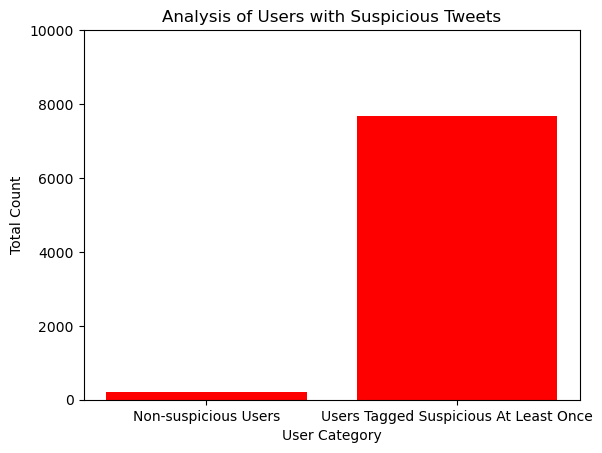

In [75]:
# Plotting
plt.bar(summary_df['Category'], summary_df['total_records'], color='red')
plt.xlabel('User Category')
plt.ylabel('Total Count')
plt.title('Analysis of Users with Suspicious Tweets')
plt.ylim(0, 10000)
plt.show()


Only about 2.7% of users have never had their tweets categorized under the suspicious categories we've defined. Clearly, we cannot simply remove such a large portion of users (~97%). To address this, we’ll define a metric called 'suspicious_percentage,' calculated as the number of times a user’s tweet is tagged as suspicious divided by their total number of tags. This metric will represent the proportion of a user’s tweets labeled as suspicious, and we can use it to filter out users accordingly

In [76]:
# Drop the 'has_suspicious_activity' column
df.drop(columns=['has_suspicious_activity'], inplace=True)

The suspicious_category_counts variable is created by summing the values across all suspicious categories for each user. 
This gives a total count of suspicious activities per user.

Similarly, total_category_counts calculates the total number of activities (across all categories) for each user.

Finally, suspicious_percentage is calculated as the ratio of suspicious activities to the total activities for each user. 
This percentage indicates how much of a user's overall activity is deemed suspicious.

In [77]:
# Calculate suspicious category counts, total counts, and suspicious percentage
suspicious_category_counts = df[suspicious_categories].sum(axis=1)
total_category_counts = df.sum(axis=1)
suspicious_percentage = suspicious_category_counts / total_category_counts

In [78]:
# Add the suspicious percentage to the DataFrame
df['suspicious_percentage'] = suspicious_percentage
df['suspicious_percentage']

0       0.065574
1       0.133333
2       0.148936
3       0.047619
4       0.200000
          ...   
7877    0.277778
7878    0.155172
7879    0.061224
7880    0.390244
7881    0.017544
Name: suspicious_percentage, Length: 7882, dtype: float64

In [79]:
# Generate a range and calculate cumulative distribution
s1 = np.arange(0, 1.0001, 0.0001)
s2 = [(df['suspicious_percentage'] < x).sum() / len(df_old) for x in s1]

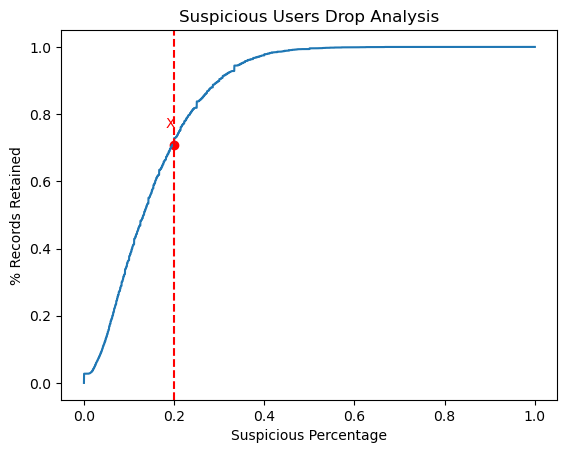

In [80]:
# Plotting Suspicious Users Drop Analysis
plt.plot(s1, s2, linestyle='-')  # Changed 'type' to 'linestyle'
plt.xlabel('Suspicious Percentage')
plt.ylabel('% Records Retained')
plt.title('Suspicious Users Drop Analysis')
plt.axvline(x=0.2, color='red', linestyle='--')
plt.scatter(0.2, s2[2000], color='red')
plt.text(0.18, s2[2000] + 0.05, "X", color='red')
plt.show()

We will set the filter threshold at 20%, meaning the users whose suspicious tweets is more than 20% of their
total tweets will be filtered out from the dataset.Threshold is marked by X in above graph. Let us filter the data and 
remove these unwanted categories

In [81]:
# Filter the data based on the suspicious percentage threshold
filtered_df = df[df['suspicious_percentage'] < 0.2].drop(columns=suspicious_categories + ['suspicious_percentage'])
print(f"We are now left with {len(filtered_df)} rows")

We are now left with 5592 rows


### This filtering process was crucial to focus the analysis on users whose activities are less likely to be dominated by spam or irrelevant content. It helps in ensuring that the subsequent steps are based on more meaningful and reliable data.

## Visualization Analysis
Let us try to plot a correlation matrix.

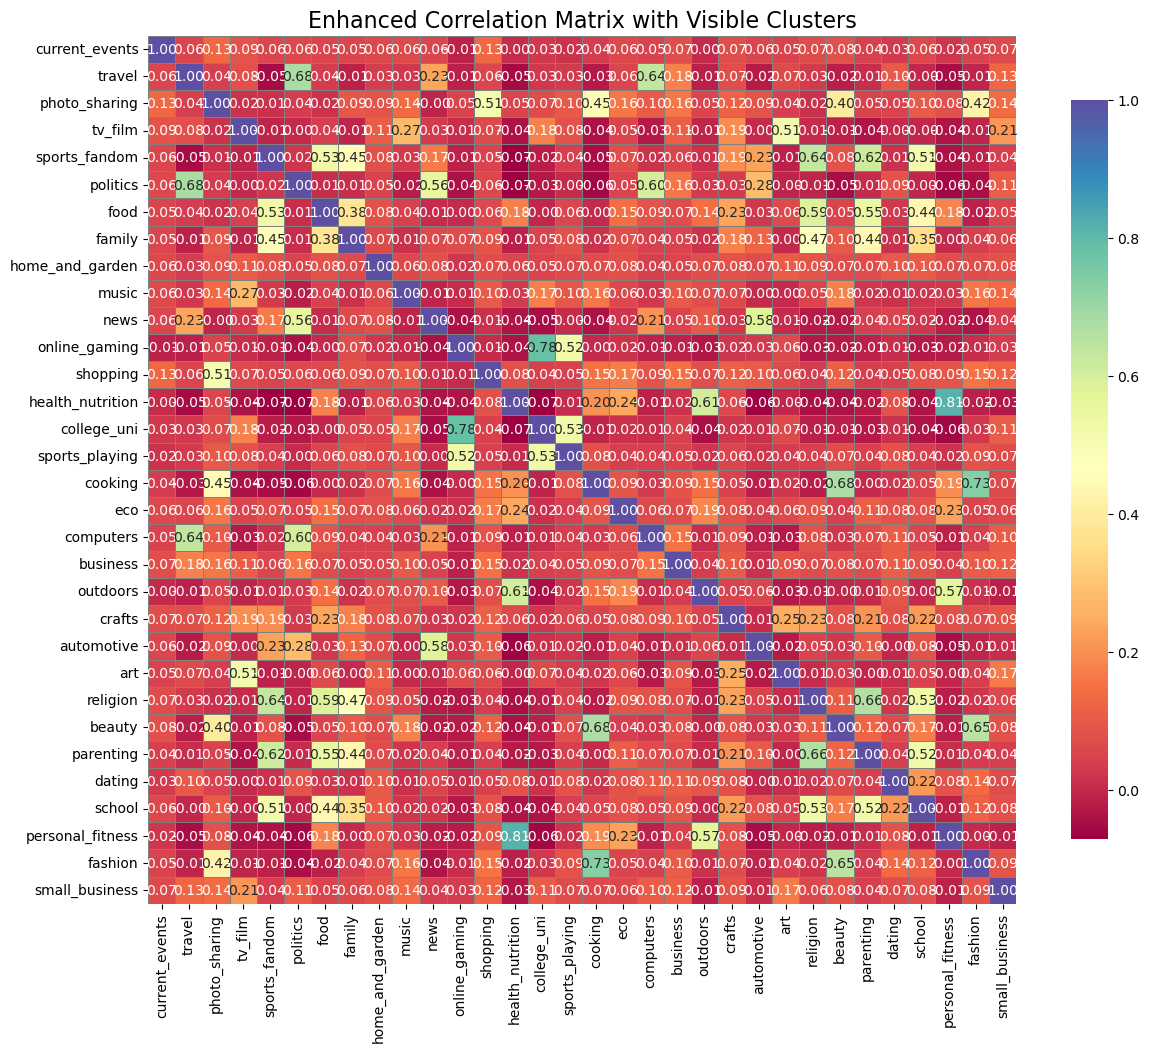

In [82]:
#Analysis and Visualization

import seaborn as sns

# Calculate correlation matrix
corr_matrix = filtered_df.corr()

# Plot the correlation matrix with enhanced visibility
plt.figure(figsize=(14, 12))  # Increased figure size
sns.heatmap(corr_matrix, cmap='Spectral', annot=True, fmt=".2f", square=True, cbar=True,
            linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.8})
plt.title('Enhanced Correlation Matrix with Visible Clusters', fontsize=16)
plt.show()

Immediately on a cursory glance, we can see some clusters in the plot above:

Lifestyle: Strong correlations might exist between cooking, fashion, beauty, and home_and_garden.

Students and Gamers: online_gaming,sports_playing,college_uni seem to correlate, reflecting student interests.

Cultural Interests: art, tv_film,food,family,sports_fandom seem to be correlated due to a shared interest in entertainment and culture.

Political and News Engagement: politics ,travel and news seem to be highly correlated, with potential links to current_events and travel.

Health and Fitness: health_nutrition, personal_fitness, and cooking seem to correlate strongly within this group.

### Let us try to reduce the dimensions using Principal Component Analysis

In [83]:
#Principal Component Analysis (PCA)

# Standardize the data
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler(with_mean=True, with_std=False)
Z = scaler.fit_transform(filtered_df)

In [84]:
# Perform PCA
pca = PCA(n_components=10)
pca.fit(Z)


PCA(n_components=10)

In [85]:
# Capture the results
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create a DataFrame to summarize the results
pca_summary = pd.DataFrame({
    'Component': np.arange(1, 11),
    'Standard Deviation': np.sqrt(explained_variance),
    'Proportion of Variance': explained_variance_ratio,
    'Cumulative Proportion': cumulative_variance_ratio
})

# Display the summary
pca_summary

,Component,Standard Deviation,Proportion of Variance,Cumulative Proportion
0,1,5.753916,0.221717,0.221717
1,2,4.477376,0.134252,0.355969
2,3,4.317003,0.124807,0.480776
3,4,4.199169,0.118086,0.598862
4,5,3.625283,0.088015,0.686877
5,6,2.447368,0.040112,0.726989
6,7,2.400296,0.038584,0.765572
7,8,2.245874,0.033779,0.799351
8,9,1.793203,0.021534,0.820886
9,10,1.599307,0.017129,0.838015


Inference:Clearly, we can observe that the proportion of variance explained increases very little after the addition of
the 6th component. Thus, we will go ahead with 5 components and analyze them one by one

In [86]:

pca = PCA(n_components=5)
pc_Z = pca.fit(Z)



In [87]:
explained_variance = pc_Z.explained_variance_
explained_variance_ratio = pc_Z.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create a DataFrame to summarize the results
pca_summary = pd.DataFrame({
    'Component': np.arange(1, 6),
    'Standard Deviation': np.sqrt(explained_variance),
    'Proportion of Variance': explained_variance_ratio,
    'Cumulative Proportion': cumulative_variance_ratio
})

# Display the summary
pca_summary

,Component,Standard Deviation,Proportion of Variance,Cumulative Proportion
0,1,5.753916,0.221717,0.221717
1,2,4.477376,0.134252,0.355969
2,3,4.317003,0.124807,0.480776
3,4,4.199169,0.118086,0.598862
4,5,3.625283,0.088015,0.686877


#### Checking how are the individual PCs loaded on the original variables

In [88]:
loadings = pca.components_.T

In [39]:
# Analyze PC1
# To see the top 10 variables contributing to PC1 (head)
o1_head = np.argsort(-loadings[:, 0])[:10]
print("Top 10 variables contributing to PC1:")
print(filtered_df.columns[o1_head])

# To see the bottom 10 variables contributing to PC1 (tail)
o1_tail = np.argsort(loadings[:, 0])[:10]
print("Bottom 10 variables contributing to PC1:")
print(filtered_df.columns[o1_tail])

Top 10 variables contributing to PC1:
Index(['health_nutrition', 'personal_fitness', 'cooking', 'outdoors',
       'photo_sharing', 'fashion', 'food', 'shopping', 'beauty', 'eco'],
      dtype='object')
Bottom 10 variables contributing to PC1:
Index(['politics', 'college_uni', 'travel', 'online_gaming', 'news',
       'sports_fandom', 'automotive', 'tv_film', 'religion', 'computers'],
      dtype='object')


#### PC1 helps outline health and personal care categories. Now analyzing PC2

In [90]:
# Analyze PC2
# To see the top 10 variables contributing to PC2 (head)
o2_head = np.argsort(-loadings[:, 1])[:10]
print("Top 10 variables contributing to PC2:")
print(filtered_df.columns[o2_head])

# To see the bottom 10 variables contributing to PC2 (tail)
o2_tail = np.argsort(loadings[:, 1])[:10]
print("Bottom 10 variables contributing to PC2:")
print(filtered_df.columns[o2_tail])

Top 10 variables contributing to PC2:
Index(['cooking', 'photo_sharing', 'fashion', 'college_uni', 'online_gaming',
       'beauty', 'shopping', 'sports_playing', 'music', 'art'],
      dtype='object')
Bottom 10 variables contributing to PC2:
Index(['health_nutrition', 'politics', 'personal_fitness', 'news', 'travel',
       'outdoors', 'food', 'computers', 'automotive', 'sports_fandom'],
      dtype='object')


#### PC2 does not seem to be clearly defined

### Let us now try to visualize these Principal Components together in a bi-variate plot

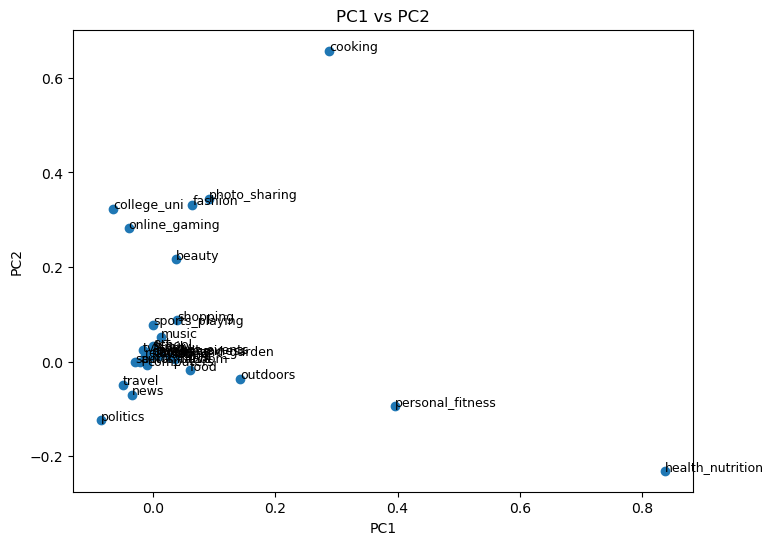

In [43]:
# Plot PC1 vs PC2
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 0], loadings[:, 1])  # PC1 on x-axis, PC2 on y-axis
for j in range(loadings.shape[0]):
    plt.text(loadings[j, 0], loadings[j, 1], filtered_df.columns[j], fontsize=9)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2')
plt.show()

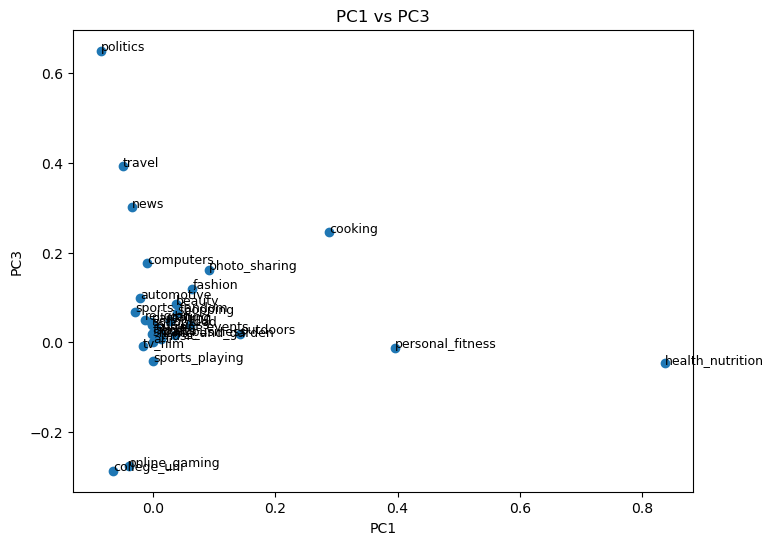

In [44]:
# Plot PC1 vs PC3
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 0], loadings[:, 2])  # PC1 on x-axis, PC3 on y-axis
for j in range(loadings.shape[0]):
    plt.text(loadings[j, 0], loadings[j, 2], filtered_df.columns[j], fontsize=9)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('PC1 vs PC3')
plt.show()

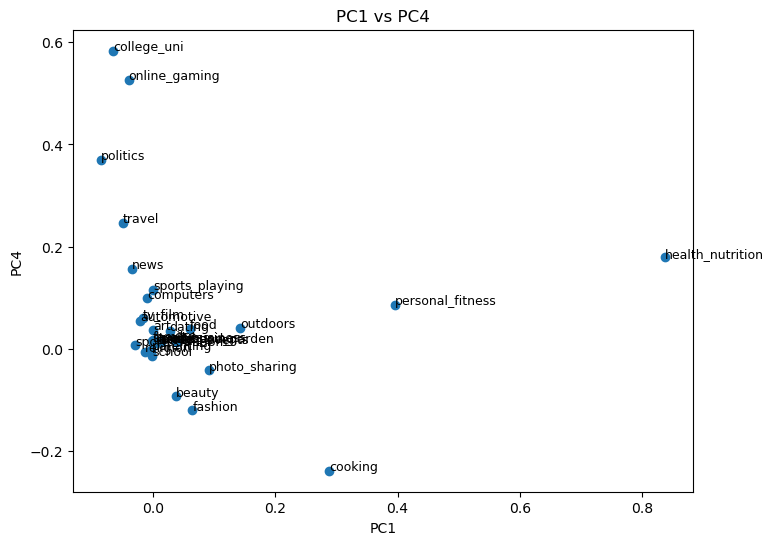

In [46]:
# Plot PC1 vs PC4
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 0], loadings[:, 3])
for j in range(loadings.shape[0]):
    plt.text(loadings[j, 0], loadings[j, 3], filtered_df.columns[j], fontsize=9)
plt.xlabel('PC1')
plt.ylabel('PC4')
plt.title('PC1 vs PC4')
plt.show()


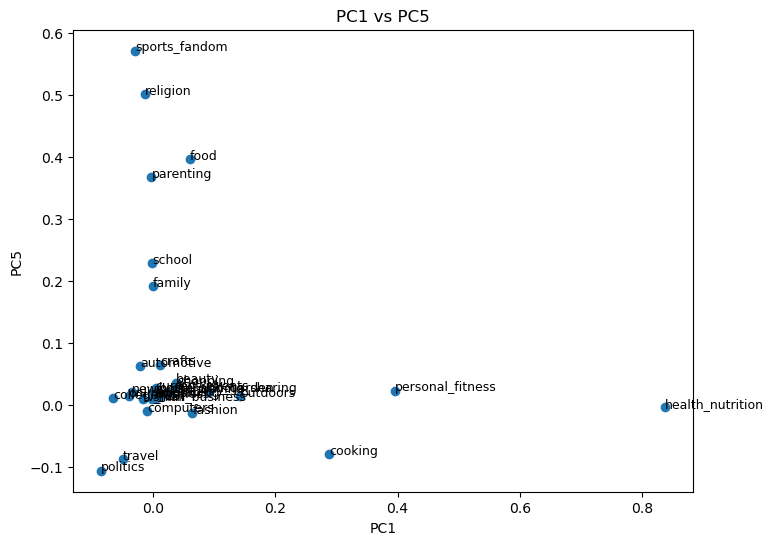

In [47]:
# Plot PC1 vs PC5
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 0], loadings[:, 4])
for j in range(loadings.shape[0]):
    plt.text(loadings[j, 0], loadings[j, 4], filtered_df.columns[j], fontsize=9)
plt.xlabel('PC1')
plt.ylabel('PC5')
plt.title('PC1 vs PC5')
plt.show()

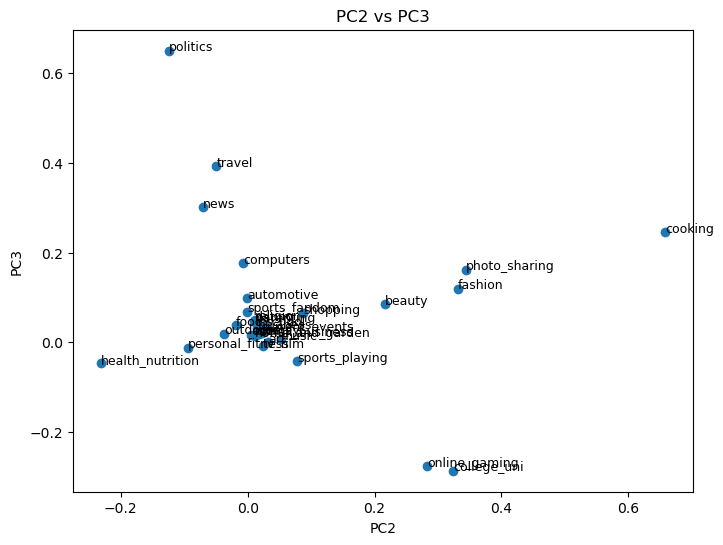

In [48]:
# Plot PC2 vs PC3
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 1], loadings[:, 2])
for j in range(loadings.shape[0]):
    plt.text(loadings[j, 1], loadings[j, 2], filtered_df.columns[j], fontsize=9)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PC2 vs PC3')
plt.show()




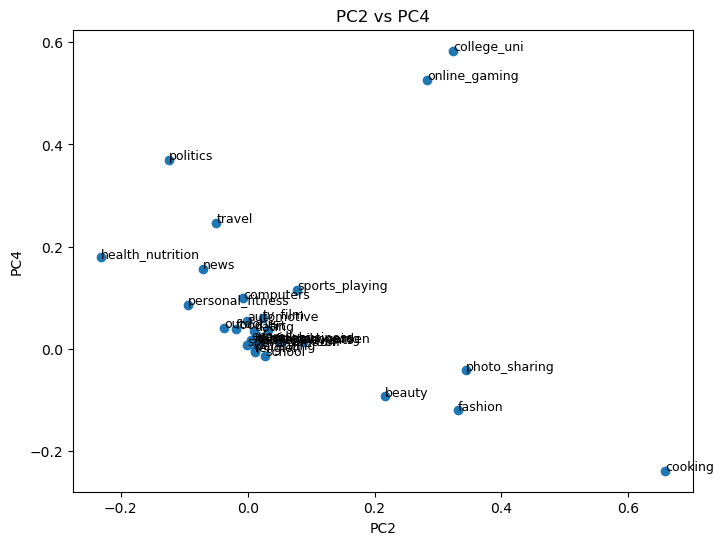

In [49]:
# Plot PC2 vs PC4
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 1], loadings[:, 3])
for j in range(loadings.shape[0]):
    plt.text(loadings[j, 1], loadings[j, 3], filtered_df.columns[j], fontsize=9)
plt.xlabel('PC2')
plt.ylabel('PC4')
plt.title('PC2 vs PC4')
plt.show()

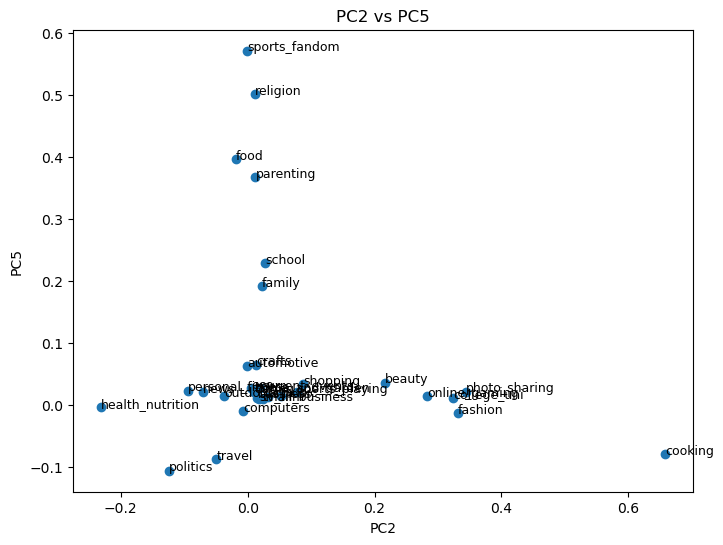

In [50]:
# Plot PC2 vs PC5
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 1], loadings[:, 4])
for j in range(loadings.shape[0]):
    plt.text(loadings[j, 1], loadings[j, 4], filtered_df.columns[j], fontsize=9)
plt.xlabel('PC2')
plt.ylabel('PC5')
plt.title('PC2 vs PC5')
plt.show()

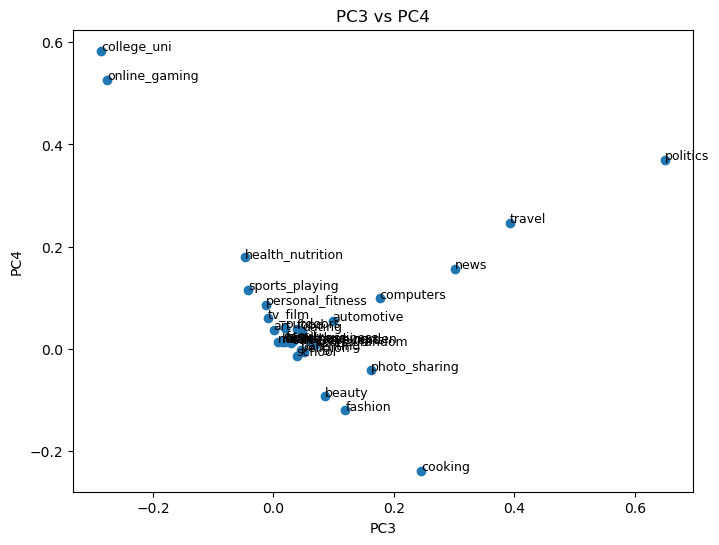

In [51]:

# Plot PC3 vs PC4
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 2], loadings[:, 3])
for j in range(loadings.shape[0]):
    plt.text(loadings[j, 2], loadings[j, 3], filtered_df.columns[j], fontsize=9)
plt.xlabel('PC3')
plt.ylabel('PC4')
plt.title('PC3 vs PC4')
plt.show()



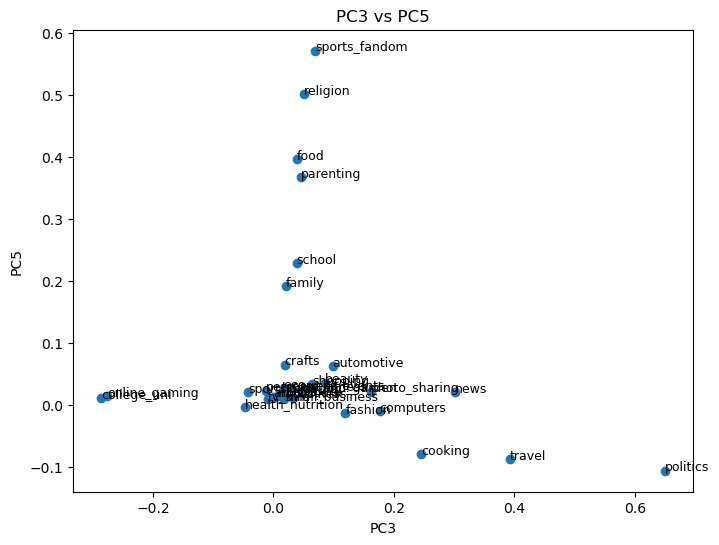

In [52]:
# Plot PC3 vs PC5
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 2], loadings[:, 4])
for j in range(loadings.shape[0]):
    plt.text(loadings[j, 2], loadings[j, 4], filtered_df.columns[j], fontsize=9)
plt.xlabel('PC3')
plt.ylabel('PC5')
plt.title('PC3 vs PC5')
plt.show()

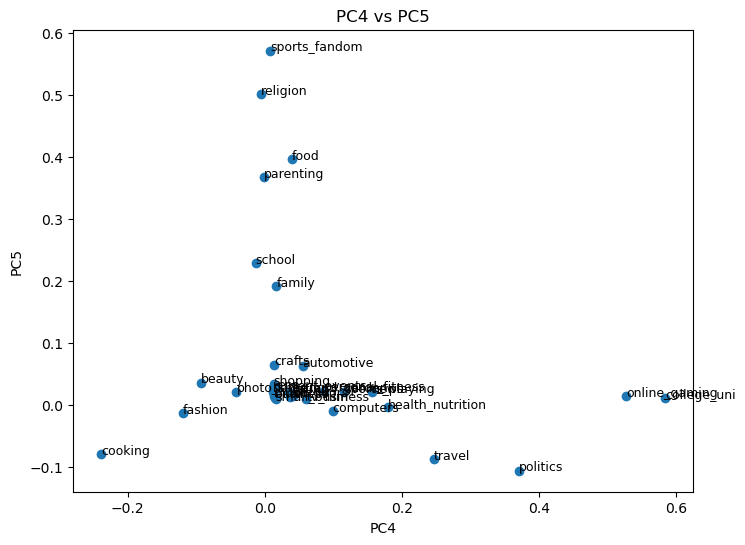

In [53]:

# Plot PC4 vs PC5
plt.figure(figsize=(8, 6))
plt.scatter(loadings[:, 3], loadings[:, 4])
for j in range(loadings.shape[0]):
    plt.text(loadings[j, 3], loadings[j, 4], filtered_df.columns[j], fontsize=9)
plt.xlabel('PC4')
plt.ylabel('PC5')
plt.title('PC4 vs PC5')
plt.show()


Observations:

PC4 vs. PC5: This plot separates the family cluster from other clusters; the student cluster is also observed on the left side.
PC4 vs. PC2: This plot distinguishes the social media influencers cluster from the others.

### A more efficient approach maybe is to cluster these PCs and see which of them are similar

In [91]:
import pandas as pd
from sklearn.cluster import KMeans

# Convert the loadings to a DataFrame with the original column names
loadings_df = pd.DataFrame(loadings[:, :5], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=filtered_df.columns)

# Perform K-means clustering
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(loadings_df)

# Add cluster assignments to the DataFrame
loadings_df['Cluster'] = clusters

# Analyze cluster sizes
cluster_sizes = loadings_df['Cluster'].value_counts().sort_index()

# Order the clusters
ordered_clusters = loadings_df.sort_values(by='Cluster')

# Display cluster sizes and ordered clusters with the original column names
cluster_sizes, ordered_clusters[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'Cluster']]


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(Cluster
 0     2
 1    20
 2     3
 3     1
 4     3
 5     3
 Name: count, dtype: int64,
                        PC1       PC2       PC3       PC4       PC5  Cluster
 online_gaming    -0.040162  0.282344 -0.276188  0.526815  0.013667        0
 college_uni      -0.065016  0.323580 -0.285992  0.583515  0.010326        0
 current_events    0.004063  0.019435  0.029712  0.011892  0.026802        1
 personal_fitness  0.395522 -0.094658 -0.012020  0.086498  0.022800        1
 dating            0.026865  0.009669  0.048051  0.035274  0.020646        1
 beauty            0.037659  0.216466  0.085114 -0.093061  0.035297        1
 art              -0.000447  0.032513  0.000155  0.037454  0.012677        1
 automotive       -0.021128 -0.001322  0.098205  0.055308  0.062041        1
 crafts            0.011549  0.013207  0.018386  0.013149  0.064350        1
 outdoors          0.142270 -0.036597  0.018905  0.041405  0.014093        1
 business          0.004706  0.015282  0.031854  0.015041  0.0

We attempted to analyze all the principal components (PCs) to clearly identify the traits they distinguish, but we 
found it challenging to interpret them effectively. Since this is a marketing segmentation problem, having a clear 
understanding of what each PC represents is crucial. However, due to the lack of clarity in deciphering the PCs, we
decided to abandon this approach and instead apply K-means++ clustering directly on the entire dataset.

## K Means for Entire data

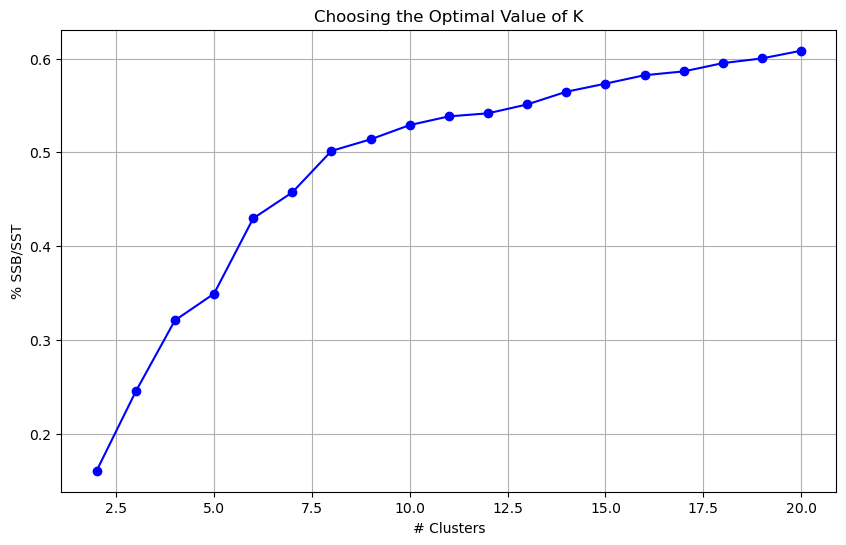

In [92]:
#K mean clustering of principal components

# Initialize variables to store the results
ratios = []
clust_counter = range(2, 21)

# Perform K-means clustering for each value of k and calculate the SSB/SST ratio
for clust_count in clust_counter:
    kmeans = KMeans(n_clusters=clust_count, init='k-means++', random_state=42)
    kmeans.fit(Z)
    ssb = kmeans.inertia_  # This is the within-cluster sum of squares (inertia)
    sst = np.sum((Z - np.mean(Z, axis=0))**2)  # Total sum of squares
    ratio = 1 - ssb/sst  # SSB/SST ratio
    ratios.append(ratio)

# Plot the ratio vs the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(clust_counter, ratios, marker='o', linestyle='-', color='b')
plt.xlabel('# Clusters')
plt.ylabel('% SSB/SST')
plt.title('Choosing the Optimal Value of K')
plt.grid(True)
plt.show()

Along expected lines, optimal number of clusters = 6 Let us fit the final K means model to cluster it

In [93]:
Z = scaler.fit_transform(filtered_df)

# Step 2: Perform K-means clustering with k=6
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans.fit(Z)

KMeans(n_clusters=6, random_state=42)

In [94]:
# Step 3: Assign cluster labels to each record
cluster_labels = kmeans.labels_

# Step 4: Add cluster labels to the DataFrame
analysis_df = pd.DataFrame(Z, columns=filtered_df.columns)
analysis_df['Cluster'] = cluster_labels

In [95]:
# Step 5: Identify the top category for each row (excluding the 'Cluster' column)
top_category = analysis_df.drop(columns=['Cluster']).idxmax(axis=1)
analysis_df['Top_Category'] = top_category

# Step 6: Group by 'Cluster' and 'Top_Category', then count the number of records in each group
df_1 = analysis_df.groupby(['Cluster', 'Top_Category']).size().reset_index(name='Record_Count')

# Step 7: Rank the records within each cluster based on their count and select the top 5
df_1['Rank'] = df_1.groupby('Cluster')['Record_Count'].rank(method='first', ascending=False)

# Step 8: Filter to keep only the top 5 categories within each cluster
top_cat = df_1[df_1['Rank'] <= 5].copy()

Top Categories in Cluster 1:
 Top_Category  Record_Count
      cooking           374
      fashion            46
photo_sharing            35
       beauty             9
sports_fandom             7




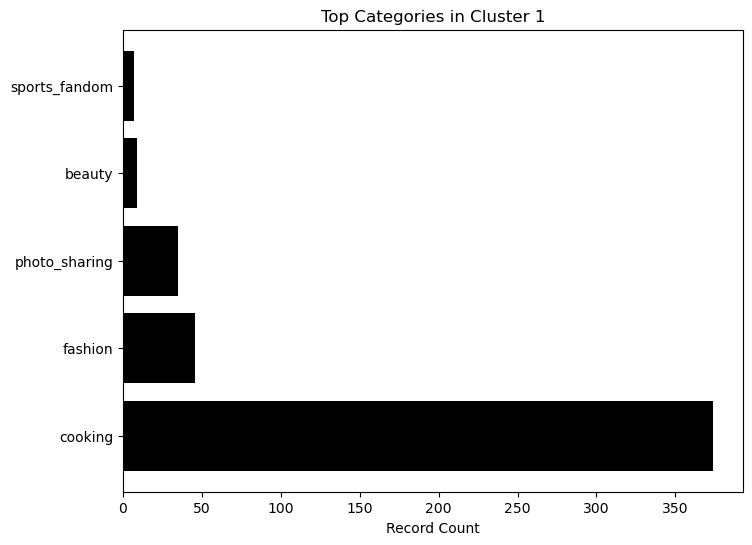

Top Categories in Cluster 2:
    Top_Category  Record_Count
   online_gaming           191
     college_uni           183
   sports_fandom             4
health_nutrition             2
        religion             2




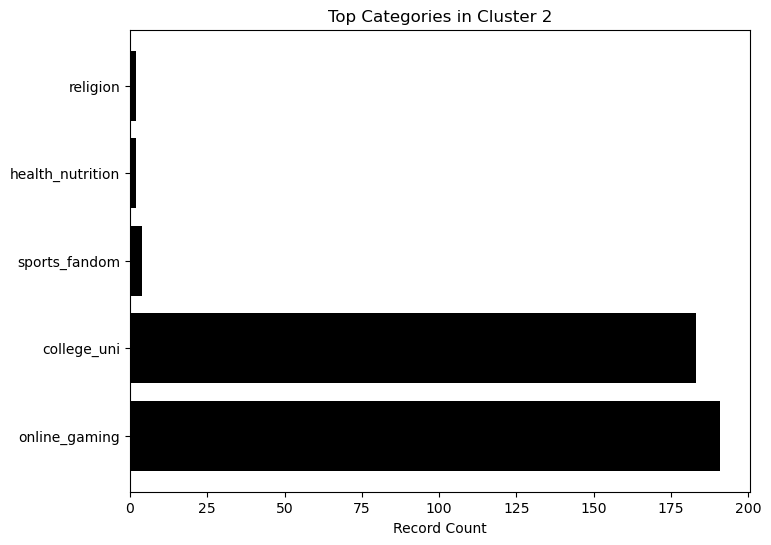

Top Categories in Cluster 3:
 Top_Category  Record_Count
sports_fandom           220
     religion           188
          art           182
      tv_film           180
photo_sharing           179




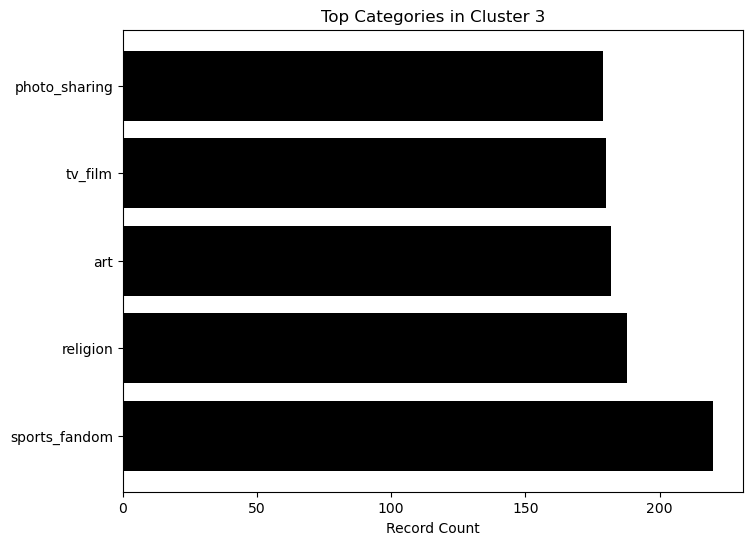

Top Categories in Cluster 4:
 Top_Category  Record_Count
     politics           212
       travel           113
photo_sharing             7
         news             4
          art             3




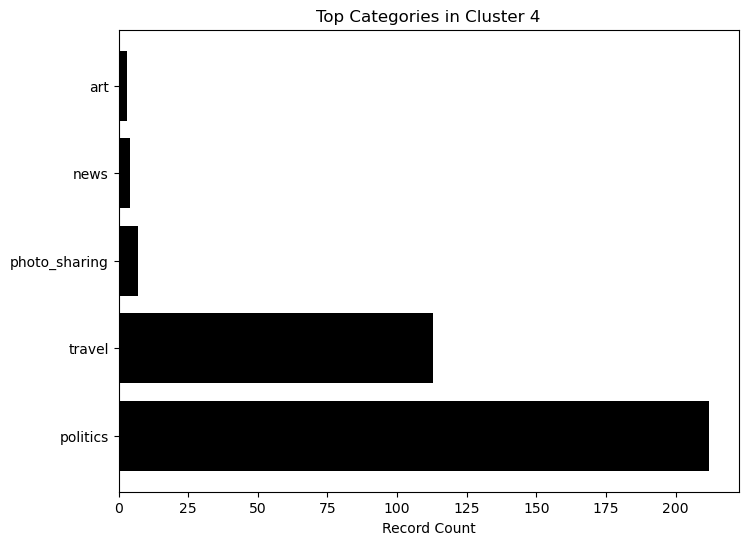

Top Categories in Cluster 5:
 Top_Category  Record_Count
         news           214
     politics            96
   automotive            60
sports_fandom            30
photo_sharing            11




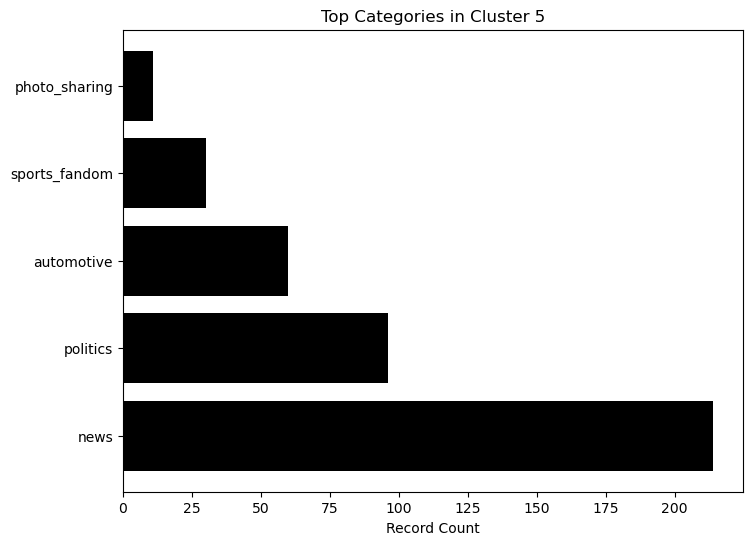

Top Categories in Cluster 6:
    Top_Category  Record_Count
health_nutrition           739
personal_fitness            87
          dating            18
   photo_sharing            17
             art            16




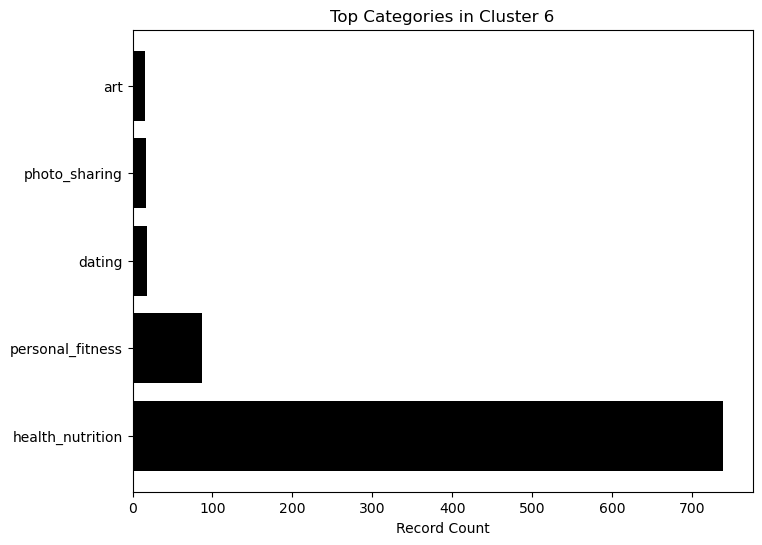

In [96]:
# Step 9: Check the top categories in each cluster and plot
for cluster_num in range(6):  # Clusters are labeled 0 to 5 in Python
    bar_df = top_cat[top_cat['Cluster'] == cluster_num].sort_values(by='Record_Count', ascending=False)
    
    print(f"Top Categories in Cluster {cluster_num + 1}:")
    print(bar_df[['Top_Category', 'Record_Count']].to_string(index=False))
    print("\n")
    
    # Plot the top 5 categories in each cluster
    plt.figure(figsize=(8, 6))
    plt.barh(bar_df['Top_Category'], bar_df['Record_Count'], color='black')
    plt.xlabel('Record Count')
    plt.title(f'Top Categories in Cluster {cluster_num + 1}')
    plt.show()


### Clustering Insights.

Cluster 1: Home and Lifestyle Enthusiasts
Top Categories:
Cooking: 374
Fashion: 46
Photo Sharing: 35
Beauty: 9
Sports Fandom: 7
    
    
Inference:
This cluster is predominantly composed of users interested in home and lifestyle topics. The strong focus on cooking suggests these users might be food enthusiasts or home cooks. The presence of fashion, beauty, and photo-sharing indicates a broader interest in lifestyle, personal appearance, and sharing their experiences online.

Cluster 2: Students and Gamers
    
    
Top Categories:
Online Gaming: 191
College/University: 183
Sports Fandom: 4
Health/Nutrition: 2
Religion: 2
    
Inference:
This cluster seems to be dominated by students and gamers. The significant presence of online gaming and college/university categories indicates that these users are likely younger, possibly students with a strong interest in gaming. The lower counts in sports fandom, health/nutrition, and religion suggest these are secondary interests.

Cluster 3: Cultural and Artistic Enthusiasts
    
Top Categories:
Sports Fandom: 220
Religion: 188
Art: 182
TV/Film: 180
Photo Sharing: 179
    
Inference:
This cluster appears to consist of users with a strong inclination toward cultural and artistic pursuits. Sports fandom 
is the most prominent, but the high numbers in art, religion, TV/film, and photo-sharing suggest these users have diverse
interests in cultural activities and likely enjoy engaging with content related to entertainment, art, and spirituality.

Cluster 4: Politically Engaged Travelers

Top Categories:
Politics: 212
Travel: 113
Photo Sharing: 7
News: 4
Art: 3
    
Inference:
Users in this cluster are likely to be politically aware and engaged, with a strong interest in travel. The high 
record count in politics suggests that these users frequently engage with political content. Their interest in travel 
and photo-sharing indicates that they enjoy exploring new places and sharing their experiences, possibly reflecting a 
global outlook.

Cluster 5: News and Automotive Enthusiasts
    
Top Categories:
News: 214
Politics: 96
Automotive: 60
Sports Fandom: 30
Photo Sharing: 11
    
Inference:
    
This cluster is characterized by a strong interest in news and politics, with a significant segment also 
focused on automotive topics. Users in this cluster likely keep themselves informed about current events 
and enjoy discussions about politics. The presence of automotive as a top category suggests an additional
interest in cars and possibly other vehicles.

Cluster 6: Health and Fitness Enthusiasts
    
Top Categories:
Health/Nutrition: 739
Personal Fitness: 87
Dating: 18
Photo Sharing: 17
Art: 16
    
Inference:
This cluster is dominated by users who are highly focused on health and fitness. The overwhelming presence of 
health/nutrition and personal fitness as top categories indicates that these users are likely fitness enthusiasts, 
possibly interested in maintaining a healthy lifestyle. The smaller interests in dating, photo-sharing, and art 
suggest that these users also engage in social interactions and appreciate creative content, but these are 
secondary to their primary focus on health.

Summary of Cluster Characteristics:

Cluster 1: Home and Lifestyle Enthusiasts - Focused on cooking, fashion, and beauty.

Cluster 2: Students and Gamers - Dominated by online gaming and college-related content.

Cluster 3: Cultural and Artistic Enthusiasts - Interested in sports, art, religion, and entertainment.

Cluster 4: Politically Engaged Travelers - Focused on politics and travel, with a global outlook.

Cluster 5: News and Automotive Enthusiasts - Interested in news, politics, and automotive content.

Cluster 6: Health and Fitness Enthusiasts - Strongly focused on health, nutrition, and fitness.

## So, clearly these clusters are consistent with what we observed in the correlation plot during our EDA.